[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana3/Autoencoders_Detecciondefraude.ipynb)

# Dependencias

In [ ]:
# Puede no ser necesaria si ya tienen instalado plotly
!pip install -U plotly

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, mean_squared_error, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

import seaborn as sns

In [ ]:
pio.templates.default = 'plotly_white'

# Datos

Utilizaremos los mismo datos de la clase pasada

https://www.kaggle.com/mlg-ulb/creditcardfraud/data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Cruso-ApsFinancieras/semana3/creditcard.csv")
df

Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.098698  0.363787  ... -0.018307  0.277838   
1      -0.082361 -0.078803  0.085102 -0.255425  ... -0.225775 -0.638672   
2       1.800499  0.791461  0.247676 -1.514654  ...  0.247998  0.771679   
3       1.247203  0.237609  0.377436 -1.387024  ... -0.108300  0.005274   
4       0.095921  0.592941 -0.270533  0.817739  ... -0.009431  0.798278   
...          ...       ...       ...       ...  ...       ...       ...   
284802 -2.606837 -4.918215  7.305334  1.914428  ...  0.213454  0.111864   
284803  1.058415  0.024330  0.294869  0.584800  ...  0.214205  0.924384   
284804  3.031260 -0.296827  0.708417  0.432454  ...  0.232045  0.578229   
284805  0.623708 -0.686180  0.679145  0.392087  ...  0.265245  0.800049   
284806 -0.649617  1.577006 -0.414650  0.486180  ...  0.261057  0.643078   

             V23       V24       V25       V26       V27       V28  Amount  \
0      -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053  149.62   
1       0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724    2.69   
2       0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752  378.66   
3      -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458  123.50   
4      -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   69.99   
...          ...       ...       ...       ...       ...       ...     ...   
284802  1.014480 -0.509348  1.436807  0.250034  0.943651  0.823731    0.77   
284803  0.012463 -1.016226 -0.606624 -0.395255  0.068472 -0.053527   24.79   
284804 -0.037501  0.640134  0.265745 -0.087371  0.004455 -0.026561   67.88   
284805 -0.163298  0.123205 -0.569159  0.546668  0.108821  0.104533   10.00   
284806  0.376777  0.008797 -0.473649 -0.818267 -0.002415  0.013649  217.00   

        Class  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
284802      0  
284803      0  
284804      0  
284805      0  
284806      0  

[284807 rows x 31 columns]

In [ ]:
# El resultado seria 'False' si NO hay valores nulos y sería 'True' si SI hay valores nulos
df.isnull().values.any()

False

In [ ]:
# 0: Normal
# 1: Fraudulento

print(df.Class.value_counts())
df.Class.value_counts() / len(df)

0    284315
1       492
Name: Class, dtype: int64


0    0.998273
1    0.001727
Name: Class, dtype: float64

In [ ]:
df[df.Class == 0].Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [ ]:
df[df.Class == 1].Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [ ]:
# Separación de características
X = df.iloc[:, 1:-1]
X

V1         V2        V3        V4        V5        V6  \
0       -1.359807  -0.072781  2.536347  1.378155 -0.338321  0.462388   
1        1.191857   0.266151  0.166480  0.448154  0.060018 -0.082361   
2       -1.358354  -1.340163  1.773209  0.379780 -0.503198  1.800499   
3       -0.966272  -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4       -1.158233   0.877737  1.548718  0.403034 -0.407193  0.095921   
...           ...        ...       ...       ...       ...       ...   
284802 -11.881118  10.071785 -9.834783 -2.066656 -5.364473 -2.606837   
284803  -0.732789  -0.055080  2.035030 -0.738589  0.868229  1.058415   
284804   1.919565  -0.301254 -3.249640 -0.557828  2.630515  3.031260   
284805  -0.240440   0.530483  0.702510  0.689799 -0.377961  0.623708   
284806  -0.533413  -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7        V8        V9       V10  ...       V20       V21  \
0       0.239599  0.098698  0.363787  0.090794  ...  0.251412 -0.018307   
1      -0.078803  0.085102 -0.255425 -0.166974  ... -0.069083 -0.225775   
2       0.791461  0.247676 -1.514654  0.207643  ...  0.524980  0.247998   
3       0.237609  0.377436 -1.387024 -0.054952  ... -0.208038 -0.108300   
4       0.592941 -0.270533  0.817739  0.753074  ...  0.408542 -0.009431   
...          ...       ...       ...       ...  ...       ...       ...   
284802 -4.918215  7.305334  1.914428  4.356170  ...  1.475829  0.213454   
284803  0.024330  0.294869  0.584800 -0.975926  ...  0.059616  0.214205   
284804 -0.296827  0.708417  0.432454 -0.484782  ...  0.001396  0.232045   
284805 -0.686180  0.679145  0.392087 -0.399126  ...  0.127434  0.265245   
284806  1.577006 -0.414650  0.486180 -0.915427  ...  0.382948  0.261057   

             V22       V23       V24       V25       V26       V27       V28  \
0       0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1      -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724   
2       0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3       0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458   
4       0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   
...          ...       ...       ...       ...       ...       ...       ...   
284802  0.111864  1.014480 -0.509348  1.436807  0.250034  0.943651  0.823731   
284803  0.924384  0.012463 -1.016226 -0.606624 -0.395255  0.068472 -0.053527   
284804  0.578229 -0.037501  0.640134  0.265745 -0.087371  0.004455 -0.026561   
284805  0.800049 -0.163298  0.123205 -0.569159  0.546668  0.108821  0.104533   
284806  0.643078  0.376777  0.008797 -0.473649 -0.818267 -0.002415  0.013649   

        Amount  
0       149.62  
1         2.69  
2       378.66  
3       123.50  
4        69.99  
...        ...  
284802    0.77  
284803   24.79  
284804   67.88  
284805   10.00  
284806  217.00  

[284807 rows x 29 columns]

In [ ]:
# Variables objetivos
y = df.Class
y

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
normal_df = df[df.Class == 0]
fraud_df = df[df.Class == 1]

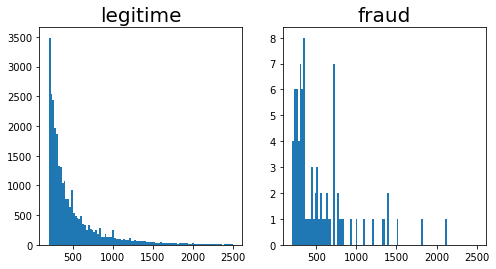

In [ ]:
bins = np.linspace(200, 2500, 100)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ax = axes.ravel()

ax[0].hist(normal_df.Amount, bins, alpha=1, label='Normal')
ax[0].set_title('legitime', fontsize=20)

ax[1].hist(fraud_df.Amount, bins, alpha=1, label='Fraud')
ax[1].set_title('fraud', fontsize=20)
plt.show()

## División en conjuntos de entrenamiento y prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)

## Normalización

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)

pd.DataFrame(X_train_norm)

0         1         2         3         4         5         6   \
0      -1.882092 -1.321882  1.413661 -0.078190  3.842890 -2.487747 -3.797281   
1       0.655471  0.283548 -0.681282  0.244626  0.695658  0.121106  0.152782   
2       0.417917 -0.724065  1.101337  0.704757 -1.112392  1.108552 -1.167868   
3      -0.393107  0.698743  0.557529 -0.204796 -0.004891 -0.103585  0.206754   
4       1.011442 -0.203541 -0.275393  0.259687 -0.260944 -0.009996 -0.472747   
...          ...       ...       ...       ...       ...       ...       ...   
227840 -0.498418  0.686418 -0.368985 -0.333457 -0.089375 -0.864715  0.226927   
227841 -0.541145  0.150146  1.758138 -1.302883  0.007429  1.070212 -0.307949   
227842 -0.770340  0.496985  0.560356  0.223067  0.363526 -0.251119  0.223270   
227843 -0.701165  0.866263  1.039118  1.332136 -0.137584  0.676139 -0.039435   
227844  1.056015 -0.055230 -0.748553  0.271673 -0.087986 -0.856513  0.116459   

              7         8         9   ...        19        20        21  \
0      -0.568938  1.094824  0.114291  ... -1.993085  0.386647 -2.328849   
1       0.044256 -0.305099 -0.430260  ... -0.067691 -0.202250 -0.501436   
2       0.599177  1.777109 -0.359421  ...  0.023113  0.224459  0.921722   
3       0.485315 -0.650545 -0.335619  ...  0.047422 -0.250661 -0.937408   
4      -0.005193  1.161319 -0.197651  ... -0.148089  0.275192  1.190355   
...          ...       ...       ...  ...       ...       ...       ...   
227840  0.535888 -0.267268 -0.699159  ... -0.369507 -0.225705 -0.812713   
227841  0.520576  2.219066 -1.596161  ... -0.097237 -0.353466 -0.100697   
227842  0.492848 -0.997863  0.131085  ... -0.327362  0.134611  0.213420   
227843  0.560588 -0.405928  0.288001  ... -0.213542  0.274007  0.907403   
227844 -0.247885  0.577742  0.084692  ... -0.333831 -0.418898 -1.064749   

              22        23        24        25        26        27        28  
0      -9.647839  1.638404 -1.675855 -1.398267  1.299000  0.949199 -0.253870  
1      -0.373690 -2.357068  1.250908  0.963353 -0.056481  0.028267 -0.351230  
2      -0.372000 -0.383126  0.493360  1.536022  0.103691  0.087683  0.147987  
3      -0.060740 -0.874354 -0.185713  0.224021  0.312711  0.119248 -0.274001  
4       0.212749  1.091903 -0.066409 -0.498428  0.118153 -0.084258 -0.314142  
...          ...       ...       ...       ...       ...       ...       ...  
227840  0.469907 -0.152864 -0.839331  0.296614 -0.217655 -0.370372 -0.318200  
227841 -0.755499 -1.795225  0.797562  2.551335  0.477538  0.220829 -0.342550  
227842  0.342860 -0.578117 -0.088472  1.671924  0.116622  0.144829 -0.296181  
227843 -0.224534 -0.674347 -0.137185  0.253450 -0.271237  0.412764 -0.232694  
227844  0.534122 -0.206671 -0.572275  0.428484 -0.183616 -0.186631 -0.349100  

[227845 rows x 29 columns]

"If you torture the data long enough, it will confess" Ronald H. Coase

# Modelo

## Configuración del modelo

In [ ]:
input_dim = X_train_norm.shape[1] # Número de columnas: 29
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) 
learning_rate = 1e-7

In [ ]:
hidden_dim

7

In [ ]:
print(f'{1e-7: .9f}')

 0.000000100


## Arquitectura de la red

In [ ]:
# Hyperparámetros muy importantes:
# - learning rate
# - batch size

In [ ]:
# Creación de las capas del modelo
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer) # tanh
encoder2 = Dense(hidden_dim, activation="relu")(encoder)

decoder = Dense(hidden_dim, activation='relu')(encoder2) # sigmoid
decoder_f = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder_f)

In [ ]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_4 (Dense)             (None, 14)                420       
                                                                 
 dense_5 (Dense)             (None, 7)                 105       
                                                                 
 dense_6 (Dense)             (None, 7)                 56        
                                                                 
 dense_7 (Dense)             (None, 29)                232       
                                                                 
Total params: 813
Trainable params: 813
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

### Con las lineas de abajo pueden decidir que epoca de entrenamiento guardar

# cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
#                                save_best_only=True,
#                                verbose=0)

## Entrenamiento

In [ ]:
history = autoencoder.fit(X_train_norm, X_train_norm,
                          epochs=100,
                          batch_size=2048,
                          shuffle = True,
                          validation_split=.2,
                          verbose=1, 
                        #   callbacks = cp
                          ).history

Epoch 1/100
90/90 [==============================] - 1s 7ms/step - loss: 1.0557 - accuracy: 0.0556 - val_loss: 0.9878 - val_accuracy: 0.0815
Epoch 2/100
90/90 [==============================] - 1s 6ms/step - loss: 0.9755 - accuracy: 0.1022 - val_loss: 0.9533 - val_accuracy: 0.1253
Epoch 3/100
90/90 [==============================] - 0s 5ms/step - loss: 0.9468 - accuracy: 0.1408 - val_loss: 0.9291 - val_accuracy: 0.1625
Epoch 4/100
90/90 [==============================] - 0s 5ms/step - loss: 0.9218 - accuracy: 0.1806 - val_loss: 0.9042 - val_accuracy: 0.2022
Epoch 5/100
90/90 [==============================] - 0s 5ms/step - loss: 0.8930 - accuracy: 0.2213 - val_loss: 0.8755 - val_accuracy: 0.2415
Epoch 6/100
90/90 [==============================] - 0s 5ms/step - loss: 0.8660 - accuracy: 0.2524 - val_loss: 0.8538 - val_accuracy: 0.2639
Epoch 7/100
90/90 [==============================] - 0s 5ms/step - loss: 0.8476 - accuracy: 0.2777 - val_loss: 0.8401 - val_accuracy: 0.2925
Epoch 8/100
9

In [ ]:
# Comando para recuperar los datos guardados del modelos, en este caso se guardaria la mejor epoca nada mas

# autoencoder = load_model('autoencoder_fraud.h5')

## Evaluación

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y = history['loss'], name = 'loss'))
fig.add_trace(go.Scatter(y = history['val_loss'], name = 'val_loss'))
fig.update_layout(
    title = 'Pérdida del modelo',
    xaxis_title = 'Época (epoch)', 
    yaxis_title = 'Pérdida (MSE)'
)
fig.show()

In [ ]:
X_test_norm = scaler.transform(X_test)
X_test_pred = autoencoder.predict(X_test_norm)
mse = mean_squared_error(X_test_norm.T, X_test_pred.T, multioutput = 'raw_values')
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})
error_df.describe()

Reconstruction_error   True_class
count          56962.000000  56962.00000
mean               0.715336      0.00165
std                2.623600      0.04059
min                0.061149      0.00000
25%                0.275459      0.00000
50%                0.438309      0.00000
75%                0.668294      0.00000
max              215.044586      1.00000

In [ ]:
error_df

Reconstruction_error  True_class
168367              0.236430           0
110270              0.230664           0
243562              0.840718           0
74702               0.574938           0
98416               0.161303           0
...                      ...         ...
201941              0.525120           0
244413              0.456835           0
50907               0.146494           0
240691              0.236885           0
79068               0.346784           0

[56962 rows x 2 columns]

La precision y el recall son muy importantes, y a veces hay que buscar el modo de optimizarlos escogiendo un threshold adecuado.

El limite a escoger (threshold) depende de que se desea del modelo. Escoger si preferimos dejar pasar un fraude por etiquetarlo mal o si preferimos etiquetar mas como fraude e invertir en solucionarlos aunque no sean fraude.

In [ ]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
px.scatter(x = recall_rt, y = precision_rt, title = 'Precision vs. Recall', 
           labels = {
             'x': 'Recall', 
             'y': 'Precision'
           })

In [ ]:
len(threshold_rt)

45462

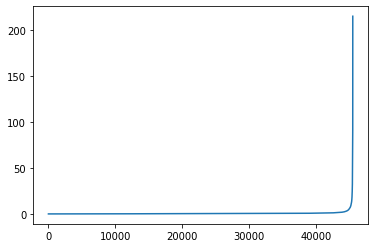

In [ ]:
# Grafica de todos los limites (threshold)
plt.plot(threshold_rt[0:])
plt.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = threshold_rt, y = precision_rt[1:], name = "Precision"))
fig.add_trace(go.Scatter(x = threshold_rt, y = recall_rt[1:], name = "Recall"))

fig.update_layout(
    title = 'Precision y Recall para diferentes umbrales', 
    xaxis_title = 'Umbral (threshold)', 
    yaxis_title = 'Precision/Recall', 
    hovermode="x unified"
)

fig.show()

In [ ]:
threshold_fixed = 47

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                    x = error_df[error_df.True_class == 0].index.to_numpy(), 
                    y = error_df[error_df.True_class == 0].Reconstruction_error, 
                    mode = 'markers', 
                    name = 'Normal'))

fig.add_trace(go.Scatter(
                    x = error_df[error_df.True_class == 1].index.to_numpy(), 
                    y = error_df[error_df.True_class == 1].Reconstruction_error, 
                    mode = 'markers', 
                    name = 'Fraude'))
fig.add_hline(threshold_fixed, annotation_text = 'Umbral fijo', line_dash = 'dash')

fig.update_layout(
    title = 'Error de reconstrucción para distintas clases', 
    yaxis_title = 'Error de Reconstrucción (MSE)', 
    xaxis_title = 'Índice del punto'
)
fig.show()

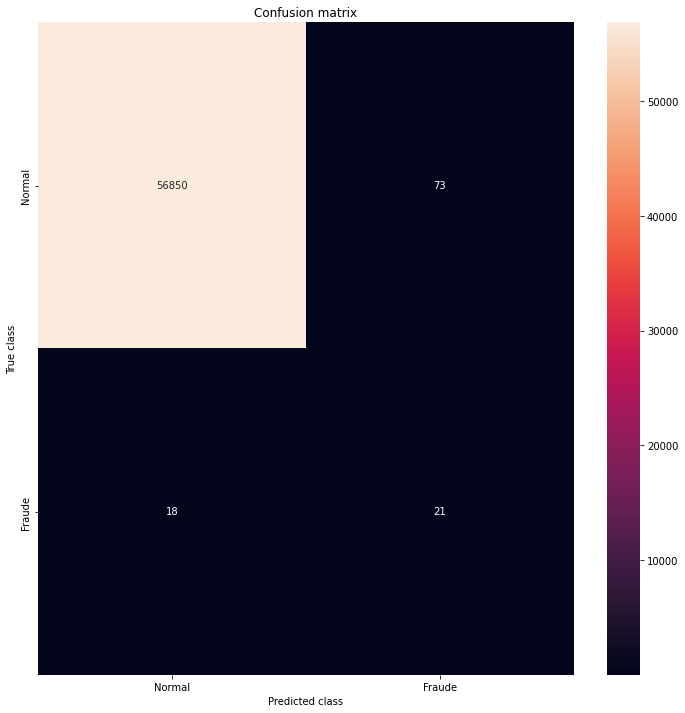

In [ ]:
pred_y = [1 if e > 47 else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(pred_y, error_df.True_class)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=['Normal', 'Fraude'], yticklabels=['Normal', 'Fraude'], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
print(classification_report(y_test, pred_y, digits = 4))

              precision    recall  f1-score   support

           0     0.9987    0.9997    0.9992     56868
           1     0.5385    0.2234    0.3158        94

    accuracy                         0.9984     56962
   macro avg     0.7686    0.6115    0.6575     56962
weighted avg     0.9980    0.9984    0.9981     56962



# Ejercicios

- Agregar más capas al encoder y/o al decoder y comparar los resultados obtenidos. Agregar muchas capas al modelo puede hacer que se sobreajuste. Una manera de mitigarlo es agregando regularización o capas Droupout. Si considera que su modelo tiene sobreajuste agregue cualquiera de las dos o elimine capas.
- ¿Cuál es la utilidad de las funciones de activación? ¿Qué operaciones hacen las distintas [funciones de activación que tiene Keras](https://keras.io/api/layers/activations/)?
- Pruebe con diferentes funciones de activación y evalue los resultados. Las funciones de activación que tiene el modelo son tanh (tangente hiperbólica) y ReLU (Rectified Linear Unit).

# Ligas

- [Post Original](https://blogs.oracle.com/ai-and-datascience/post/fraud-detection-using-autoencoders-in-keras-with-a-tensorflow-backend)

- Info. sobre pulir hiperparámetros (batch_size, learn_rate, epochs,...)
  
  *   https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/
  *   https://www.oreilly.com/library/view/natural-language-processing/9781484242674/

